# The "Online Retail" Dataset 

This is a transnational data set which contains all purchase transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. 

The dataset is composed of the following columns:


* **InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* **StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* **Description**: Product (item) name. Nominal.
* **Quantity**: The quantities of each product (item) per transaction. Numeric.
* **InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.
* **UnitPrice**: Unit price. Numeric, Product price per unit in sterling.
* **CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* **Country**: Country name. Nominal, the name of the country where each customer resides.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from recsys.data import load_original_ecomm, preprocess_ecomm, construct_session_sequences 

In [23]:
import seaborn as sns
plt.style.use("seaborn-white")
cldr_colors = ['#00b6b5', '#f7955b','#6c8cc7', '#828282']#
cldr_green = '#a4d65d'
color_palette = "viridis"

## Getting the dataset

We obtained the Online Retail dataset from the Kaggle website found [here](https://www.kaggle.com/vijayuv/onlineretail). 
The data is open source but you will need to register on Kaggle's website before downloading. 

Once downloaded, we created some helper functions for opening and processing this dataset. 

In [39]:
df = load_original_ecomm()

In [25]:
df.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


These purchase histories record transactions for each customer and detail the items that were purchased in each transaction. Each transaction has a unique InvoiceNo, a time stamp (InvoiceDate) and the CustomerID of the purchaser. 

## Preprocessing

There are some rows with missing information, so we'll filter those out. Since we want to define customer sessions, we'll use group by CustomerID field and filter out any customer entries that have fewer than three purchased items.

In [47]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [48]:
df.dropna(inplace=True)

In [49]:
# filter out sessions that have fewer than 3 items
item_counts = df.groupby(["CustomerID"]).count()["StockCode"]
df = df[
    df["CustomerID"].isin(item_counts[item_counts >= 3].index)
].reset_index(drop=True)

In [50]:
item_counts

CustomerID
12346.0      2
12347.0    182
12348.0     31
12349.0     73
12350.0     17
          ... 
18280.0     10
18281.0      7
18282.0     13
18283.0    756
18287.0     70
Name: StockCode, Length: 4372, dtype: int64

## Dataset Statistics

In [29]:
# Number of unique customers after preprocessing
df.CustomerID.nunique()

4234

In [30]:
# Number of unique stock codes (products)
df.StockCode.nunique()

3684

### Product popularity

Here we plot the frequency by which each product is purchased (occurs in a transaction). 

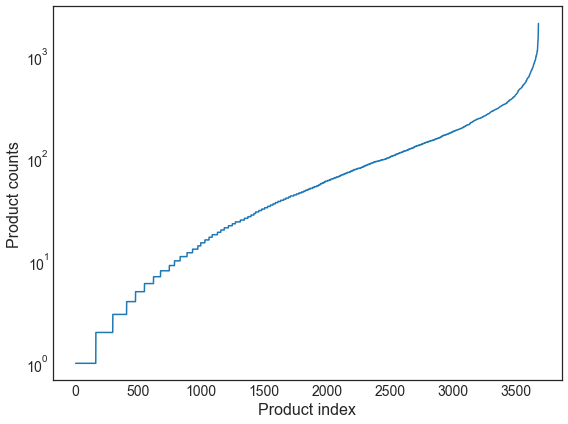

In [31]:
plt.style.use("seaborn-white")

# Number of unique customer IDs
product_counts = df.groupby(['StockCode']).count()['InvoiceNo'].values

fig = plt.figure(figsize=(8,6))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.semilogy(sorted(product_counts))
plt.ylabel("Product counts", fontsize=16);
plt.xlabel("Product index", fontsize=16);

plt.tight_layout()

The left side of the figure corresponds to products that are not very popular (because they aren't purchased very often), while the far right side indicates that some products are *extremely* popular and have been purchased hundreds of times. 

### Customer session lengths 

We define a customer's "session" as all the products they purchased in each transaction, in the order in which they were purchased (ordered InvoiceDate). We can then examine statistics regarding the length of these sessions. Below is a boxplot of all customer session lengths.  

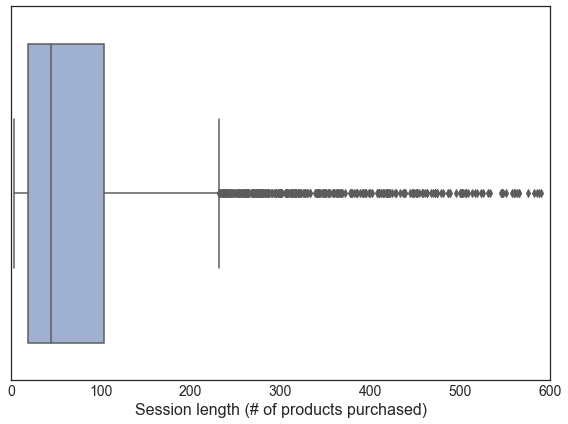

In [78]:
session_lengths = df.groupby("CustomerID").count()['InvoiceNo'].values

fig = plt.figure(figsize=(8,6))
plt.xticks(fontsize=14)

ax = sns.boxplot(x=session_lengths, color=cldr_colors[2])

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
    
plt.xlim(0,600)
plt.xlabel("Session length (# of products purchased)", fontsize=16);

plt.tight_layout()
plt.savefig("../../recommendations/docs/images/session_lengths.png", transparent=True, dpi=150)

In [57]:
print("Minimum session length: \t", min(session_lengths))
print("Maximum session length: \t", max(session_lengths))
print("Mean session length: \t \t", np.mean(session_lengths))
print("Median session length: \t \t", np.median(session_lengths))
print("Total number of purchases: \t", np.sum(session_lengths))

Minimum session length: 	 3
Maximum session length: 	 7983
Mean session length: 	 	 96.03967879074162
Median session length: 	 	 44.0
Total number of purchases: 	 406632


## Misc 

In [63]:
customer_grps.get_group(custIDs[0])['InvoiceDate'].diff().max()

Timedelta('69 days 23:11:00')

In [66]:
len(customer_grps.get_group(custIDs[0])['StockCode'])

312

In [66]:
customer_grps = df.groupby("CustomerID")
max_time_diff = []

for custID, history in customer_grps:
    max_time_diff.append(history['InvoiceDate'].diff().max().days)

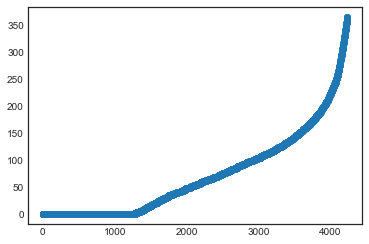

In [72]:
max_time_diff

plt.scatter(np.arange(len(max_time_diff)), sorted(max_time_diff))

In [74]:
test_grp = customer_grps.get_group(12347.0)

test_grp[['InvoiceNo','Description', 'InvoiceDate']]

,InvoiceNo,Description,InvoiceDate
10652,537626,BLACK CANDELABRA T-LIGHT HOLDER,2010-12-07 14:57:00
10653,537626,AIRLINE BAG VINTAGE JET SET BROWN,2010-12-07 14:57:00
10654,537626,COLOUR GLASS. STAR T-LIGHT HOLDER,2010-12-07 14:57:00
10655,537626,MINI PAINT SET VINTAGE,2010-12-07 14:57:00
10656,537626,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,2010-12-07 14:57:00
...,...,...,...
403109,581180,WOODLAND CHARLOTTE BAG,2011-12-07 15:52:00
403110,581180,PINK GOOSE FEATHER TREE 60CM,2011-12-07 15:52:00
403111,581180,CHRISTMAS TABLE SILVER CANDLE SPIKE,2011-12-07 15:52:00
403112,581180,MINI PLAYING CARDS SPACEBOY,2011-12-07 15:52:00


In [77]:
for invoice_date, grp in test_grp.groupby('InvoiceDate'):
    print(invoice_date)
    print(grp['Description'])

2010-12-07 14:57:00
10652        BLACK CANDELABRA T-LIGHT HOLDER
10653      AIRLINE BAG VINTAGE JET SET BROWN
10654      COLOUR GLASS. STAR T-LIGHT HOLDER
10655                MINI PAINT SET VINTAGE 
10656    CLEAR DRAWER KNOB ACRYLIC EDWARDIAN
10657     PINK DRAWER KNOB ACRYLIC EDWARDIAN
10658    GREEN DRAWER KNOB ACRYLIC EDWARDIAN
10659      RED DRAWER KNOB ACRYLIC EDWARDIAN
10660    PURPLE DRAWERKNOB ACRYLIC EDWARDIAN
10661     BLUE DRAWER KNOB ACRYLIC EDWARDIAN
10662         ALARM CLOCK BAKELIKE CHOCOLATE
10663             ALARM CLOCK BAKELIKE GREEN
10664              ALARM CLOCK BAKELIKE RED 
10665              ALARM CLOCK BAKELIKE PINK
10666            ALARM CLOCK BAKELIKE ORANGE
10667             FOUR HOOK  WHITE LOVEBIRDS
10668        BLACK GRAND BAROQUE PHOTO FRAME
10669                   BATHROOM METAL SIGN 
10670           LARGE HEART MEASURING SPOONS
10671     BOX OF 6 ASSORTED COLOUR TEASPOONS
10672      BLUE 3 PIECE POLKADOT CUTLERY SET
10673      RED 3 PIECE RETROSPOT CU